In [ ]:
'''
WeakIdent Tutorial part I: data preparation for WeakIdent

Author: Wenbo Hao
Note: the whole tutorial is adapted from the WeakIdent-Python code
developed by Dr. Mengyi Tang, available at the link below.
https://github.com/sunghakang/WeakIdent/tree/main/WeakIdent-Python

Date: 11/19/2024

Introduction:

This file is the first among two files of a tutorial for WeakIdent: a method
to identify partial differential equations from spatiotemperal data leveraging
the weak form of PDEs. This paper shows the procedure to generate the feature
matrices W and b required for the identification problem b = Wc from original
PDE data. The paper that develops this method is on
https://doi.org/10.1016/j.jcp.2023.112069. If you found WeakIdent useful in your
research, please consider citing it:

@article{tang2023weakident,
  title={WeakIdent: Weak formulation for Identifying Differential Equation using
  Narrow-fit and Trimming},
  author={Tang, Mengyi and Liao, Wenjing and Kuske, Rachel and Kang, Sung Ha},
  journal={Journal of Computational Physics},
  pages={112069},
  year={2023},
  publisher={Elsevier}
}

'''

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import scipy.linalg

In [ ]:
# Data preparation using the WeakIdent form


import pandas as pd
import time
from typing import Tuple
from scipy.optimize import brentq as root


# The main function for data preparation
def data_preparation(u_hat: np.array, xs: np.array, dict_list: np.array,
                     max_dx: int, max_poly: int, skip_x: int, skip_t: int,
                     use_cross_der: bool):

  '''
   Args:
        u_hat (np.array): array of shape (n, nx, nt). This is the given noisy
        data with n dependent variables (or # of eqns), nx spatial grids, and
        nt temporal grids. The spatial (or temporal) location increases with
        respect to row (colomn) indices.

        xs (np.array): array of shape (dim_x + 1,). all the xs, ys, and ts
        locations. ((x1, ..., xI), (y1, ..., yJ), (t1, ..., tN))

        dict_list (np.array): array of shape (L, n + dim_x + 1)
        # Remark: the first n column denote the monomial base power of each   #
        # feature. The n+1 - n+dim_x the column denotes the derivative of     #
        # monomial along x direction. The n+dim_x+1 column denotes the        #
        # derivative of monommial along t direction.                          #

        max_dx (int): maximum total order of partial derivatives.

        max_poly (int): maximum total order of monomials.

        skip_x (int): skipping steps in spatial domain when doing subsampling

        skip_t (int): skipping steps in temporal domain when doing subsampling

        use_cross_der (bool): whether to allow partial derivatives exist in the
        dictionary.
        # use_cross_der is consider only when dealing with 2d spatial domain. #

    Returns:
        W(np.array):
                  feature matrix W (including the LHS feature b) of the linear
                  system Wc = 0. Array of shape (N, L), where N is num of data
                  points, and L num of candidate terms.
    Note:
        The output W in of this function is [b|W] for b and W in the linear
        system b = Wc provided that u_t is the first candidate terms in the
        dictionary. Therefore, our revised linear system is 0 = Wc instead of
        b = Wc.
  '''

  # determine number of variables of given data.
  num_of_variables = u_hat.shape[0]

  # determine spatial dimension of given data.
  dim_x = len(u_hat[0].shape) - 1

  # determine whether given data is 1-dimensional ODE.
  is_1d_ode = u_hat[0].shape[0] == 1

  # build feature matrix W for the linear system Wc = 0
  W = build_feature_matrices(u_hat, dict_list, xs, max_dx, skip_x, skip_t,
                             is_1d_ode)

  return W


# The function to compute feature matrix W using data
def build_feature_matrices(u_hat: np.array, dict_list: np.array, xs: np.array,
                           max_dx: int, skip_x: int, skip_t: int,
                           is_1d_ode: bool):

    '''
    This function builds a feature matrix W(including both the LHS and RHS
    features for Wc = b). The revised linear system is Wc = 0

    Args:
        u_hat (np.array): array of shape (n,) , this is given noisy data with
        n variables.

        xs (np.array): array of shape (dim_x + 1,), spacing of given data.

        max_dx (int): maximum total order of partial derivatives
        (including multiple dimension derivatives).

        skip_x (int): skipping steps in spatial domain when doing subsampling

        skip_t (int): skipping steps in temporal domain when doing subsampling

        is_1d_ode (bool): whether given data is 1d-ode type.

    Returns:
        np.array:
                  W(np.array):
                  feature matrix W (including the LHS feature b) of the linear
                  system Wc = 0. Array of shape (N, L), where N is num of data
                  points, and L num of candidate terms.

    '''

    m_x, m_t, p_x, p_t = compute_test_function_para(u_hat, xs, max_dx)
    dx = 0
    if not is_1d_ode:
        dx = xs[0].flatten()[1] - xs[0].flatten()[0]
    dt = xs[-1].flatten()[1] - xs[-1].flatten()[0]

    if is_1d_ode:
      print("Error: I haven't implemented 1d ode yet")
    else:
        W = compute_feature_matrices_pde(m_x, m_t, p_x, p_t, dict_list,
                                         u_hat, dx, dt, max_dx, skip_x, skip_t)

    return W


# Find a test function for each data point (xj, t^n)
def compute_test_function_para(u: np.array, xs: np.array,
                               max_dx: int):

    """
    This function computes the size of test function and the order p in the
    test function.

    Note:
          In each spatial domain, the size of integration region of a test
          function is 2m_x + 1.

          In the temporal domain, the size of integration region of a test
          fucntion is 2m_t + 1.

          The localized test function is phi(x,t) = (1-x^2)^p_x* (1-t^2)^p_t.

    Args:
        u (np.array): array of shape (n_var,)
        xs (np.array): array of shape (dim_x + 1,)
        max_dx (int): maximum total order of partial derivatives

    Returns:
        Tuple[int, int, int, int]: m_x, m_t, p_x, p_t
    """

    m_x = []
    m_t = 0
    p_x, p_t, maxd = 0, 0, 1
    if u[0].shape[0] > 1:
        T = max(xs[-1].shape)
        maxd = xs.shape[0] - 1
    tau, tau_hat = 1e-10, 2
    L = max(xs[0].shape)
    for n in range(u.shape[0]):
        corners = find_corner_pts(u[n], xs)
        for d in range(maxd):
            N = max(xs[d].shape)
            k = corners[d]
            mstar1 = np.sqrt(3) * N / np.pi / 2 / k * tau_hat
            mstar2 = (
                1 / np.pi * tau_hat * N / 2 / k *
                np.sqrt(np.log(np.power(np.exp(1), 3) / np.power(tau, 8))))
            mnew = root(
                lambda m: np.log((2 * m - 1) / m**2) *
                (4 * np.pi**2 * k**2 * m**2 - 3 * N**2 * tau_hat**2
                 ) - 2 * N**2 * tau_hat**2 * np.log(tau),
                mstar1,
                mstar2,
            )
            if mnew > N / 2 - 1:
                mnew = N / 2 / k
            m_x.append(mnew)
            L = min(L, N)
        k = corners[-1]
        if u[0].shape[0] > 1:
            mnew = root(
                lambda m: np.log((2 * m - 1) / m**2) *
                (4 * np.pi**2 * k**2 * m**2 - 3 * T**2 * tau_hat**2
                 ) - 2 * T**2 * tau_hat**2 * np.log(tau),
                1,
                2 / np.sqrt(tau),
            )
            if mnew > T / 2 - 1:
                mnew = T / 2 / k
            m_t = mnew
    if len(m_x) == 1:
        m_x = min((L - 1) // 2, np.ceil(m_x[0]))
    else:
        m_x = min((L - 1) // 2, np.ceil(np.mean(np.asarray(m_x))))
    p_x = max(max_dx + 2,
              np.floor(np.log(tau) // np.log(1 - np.power(1 - 1 / m_x, 2))))
    if u[0].shape[0] > 1:
        m_t = min((T - 1) // 2, np.ceil(m_t))
        p_t = max(1 + 2,
                  np.floor(np.log(tau) / np.log(1 - np.power(1 - 1 / m_t, 2))))
    return int(m_x), int(m_t), int(p_x), int(p_t)


# The three functions below are helper functions for compute_test_func_para
def find_corner_pts(u: np.array, xs: np.array):

  """
  This function will find a transition frequency mode of given data in each
  dimension (spatial / temporal).

  Args:
      u (np.array): array of shape (n_x, n_y, n_t) or (n_x, n_t) for one
      variable in a given system

      xs (np.array): array of shape (dim_x + 1,)

  Remark: This function follows the method in "Weak SINDy" to find a transition
  frequency mode. The script is modified from Matlab code for Paper,
  "Weak SINDy for Partial Differential Equations" by D. A. Messenger and
  D. M. Bortz

  Returns:
      list: [k_1^*, k_2^*, k_3^*, ... ] where each k^* represent a corner
      frequency mode, the order of this
            list should be for x, y(if applicable), t.
  """

  if u.shape[0] == 1:
      dim = 1
  else:
      dims = u.shape
      dim = len(dims)
  corners = []
  for d in range(dim):
      if dim == 1:
          shift = [0, 1]
      else:
          shift = circshift([i for i in range(dim)], 1 - (d + 1))
      x = xs[d].reshape(-1, 1)
      L = len(x)
      range_of_x = np.absolute(x[-1] - x[0])
      wn = ((np.arange(L) - L // 2) * 2 * np.pi / range_of_x).reshape(-1, 1)
      NN = (len(wn) + 1) // 2
      xx = wn[:NN]
      if dim >= 2:
          ufft = np.absolute(
              np.fft.fftshift(np.fft.fft(u.transpose(tuple(shift)), axis=0)))
      else:
          ufft = np.absolute(np.fft.fftshift(np.fft.fft(u)))
      if dim == 3:
          ufft = ufft.reshape((L, -1))
      if dim >= 2:
          ufft = np.mean(ufft, axis=1).reshape((-1, 1))
      else:
          ufft = ufft.reshape((-1, 1))
      ufft = np.cumsum(ufft).reshape((-1, 1))
      ufft = ufft[:(L + 1) // 2]
      errs = np.zeros(NN - 6)
      for k in range(4, NN - 2):
          subinds1 = np.arange(k)
          subinds2 = np.arange(k - 1, NN)
          ufft_av1 = ufft[subinds1].reshape(-1, 1)
          ufft_av2 = ufft[subinds2].reshape(-1, 1)
          m1 = drange(ufft_av1) / drange(xx[subinds1])
          m2 = drange(ufft_av2) / drange(xx[subinds2])
          L1 = np.min(ufft_av1) + m1 * (xx[subinds1] - xx[0])
          L2 = np.max(ufft_av2) + m2 * (xx[subinds2] - xx[-1])
          errs[k - 4] = np.sqrt(
              np.sum(np.power((L1 - ufft_av1) / ufft_av1, 2)) +
              np.sum(np.power((L2 - ufft_av2) / ufft_av2, 2)))
      idx = np.argmin(errs)
      corners.append(NN - idx - 4)
  return corners


def circshift(l: list, d: int):

    """
    This function computes the permutation of a list l by shifting all the
    elements to the left d units.

    Args:

        l (list):  given list.

        d (int):   number of shifts.

    Returns:

        list: shifted list
    """

    if d == 0:
        return l
    else:
        return l[-d:] + l[:-d]


def drange(x: np.array) -> np.float64:

    """
    This function computes the scale of range of given data x

    Args:
        x (np.array): given data
    Returns:
        np.float64: max(x) - min(x)
    """

    return np.max(x) - np.min(x)


def compute_feature_matrices_pde(m_x: int, m_t: int, p_x: int, p_t: int,
                                 dict_list: np.array, u_hat: np.array,
                                 dx: np.array, dt: np.array,
                                 max_dx: int, skip_x: int,
                                 skip_t: int) -> np.array:

    """
    This function computes the weak feature matrix W produced by the
    candidates terms and b produced by the time derivatives of data.

    Args:

        m_x (int): 1-side size of integrating region in spatial domain.

        m_t (int): 1-side size of integrating region in temporal domain.

        p_x (int): parameter in test function in terms of x.

        p_t (int): parameter in test function in terms of t.

        skip_x (int): # skipping steps in spatial domain when downsampling
        feature matrix

        skip_t (int): # skipping steps in temporal domain when downsampling
        feature matrix

        dict_list(np.ndarray): array of shape (L, n + dim_x + 1). Here each row
                               represents a feature.Column 1 - column n
                               represents the degree of monomial for each
                               variable column n+1 - column n+dim_x represents
                               the order of partial derivatives along each
                               spatial domain, and column n+dim_x+1 represents
                               the order of partial derivatives along temporal
                               domain.

        u_hat (np.array): given data of shape (n,).

        dx (np.array): delta x (spatial increase) of given data.

        dt (np.array): delta t (temporal increase) of given data.

        max_dx (int): maximum total order of partial derivatives.

    Returns:
        W(np.array):
                  feature matrix W (including the LHS feature b) of the linear
                  system Wc = 0. Array of shape (N, L), where N is num of data
                  points, and L num of candidate terms (including u_t)

    """

    dims = u_hat[0].shape
    dim_x = len(dims) - 1

    print("mx: " + str(m_x))
    print("mt: " + str(m_t))

    # Code for computing subsampling index, meanwhile drop the mx and mt points
    # at both the left and right boundary since the test function is not defined
    # there
    subsampling_idx = []

    # Cut the 2m_x and 2m_t grids at the right boundary to avoid the issue that
    # integral domain is not well-defined at the boundary. Then do subsampling
    '''
    Note: theoretically we should get rid of m_x (or m_t) grids at the left
    boundary and m_x (or m_t at the right boundary) instead of eliminating grids
    only from one side. However, in practice, using componentwise multiplication
    in the Fourier domain for computing convolution introduce a phase shift of
    mx + 1 to the left. Therefore, we take subsampling index from 0.
    '''

    shrink_size = np.block(
        [np.ones((1, dim_x)) * m_x * 2,
         np.array([[m_t * 2]])]).flatten()
    ss = np.block([np.ones((1, dim_x)) * skip_x,
                   np.array([[skip_t]])]).flatten()
    for j in range(len(dims)):
        subsampling_idx.append(np.arange(0, dims[j] - shrink_size[j], ss[j]))


    phi_xs, phi_ts = compute_test_funs(m_x, m_t, p_x, p_t, max_dx)
    fft_phis = compute_fft_test_fun(dims, phi_xs, phi_ts, m_x, m_t, dx, dt)
    W = compute_w(dict_list, u_hat, fft_phis, subsampling_idx)
    return W


def compute_w(dict_list: np.array, u_hat: np.array, fft_phis: np.array,
              subsampling_idx: np.array):

    """
    This function computes the feature matrix W given by the candidates terms
    for identifying PDEs

    Args:

        dict_list(np.ndarray): array of shape (L, n + dim_x + 1). Here each row
                               represents a feature, column 1 - column n
                               represents the degree of monomial for each
                               variable, column n+1 - column n+dim_x represents
                               the order of partial derivatives along each
                               spatial domain, and column n+dim_x+1 represents
                               the order of partial derivatives along temporal
                               domain.

        u_hat (np.array): array of shape (n,) (given data).

        fft_phis (np.array): array of shape (max_dx+1, mathbbNx). This is the
        fft of a test functions and it's derivatives.

        subsampling_idx (np.array): array of shape (Nx , ) which stores the
        index of subsampled feature matrix.

    Returns:
        np.array: feature matrix W of the system Wc = 0
    """

    print('Start building feature matrix W:')

    # Extract num of equations, (Nx, Nt), and num of terms
    n = u_hat.shape[0]
    dim = len(u_hat[0].shape)
    L = dict_list.shape[0]

    print('subsampling_idx: ' + str(subsampling_idx))
    # Initialize subsampled W. Here W contains only the feature matrices for the
    # for the candidates function values of the n eqns
    if dim == 2:
        W = np.zeros((len(subsampling_idx[0]) * len(subsampling_idx[1]), L))
    elif dim == 3:
        W = np.zeros((len(subsampling_idx[0])**2 * len(subsampling_idx[2]), L))

    # Iterate over the candidate terms
    ind = 0
    while ind < L:
        # extract the powers for each variables for this term
        tags = dict_list[ind, :n]
        # Multiply all the minomials with their power together
        fcn = np.power(u_hat[0], tags[0])
        for k in range(1, n):
            fcn = fcn * np.power(u_hat[k], tags[k])
        while np.all(dict_list[ind, :n] == tags):
            # test_conf_cell store the fft of a test function (or it's
            # derivatives) in all spatial and temporal dimension
            test_conv_cell = []
            # Iterate over num of independent variables
            for k in range(dim):
                # Extract the discretized value for test function and its
                # derivatives corresponding to this independent variables
                temp = fft_phis[k]
                # First search for the order of derivative corresponding to this
                # term in the dict_list, then extract the discretized value for
                # the derivatives of test functions and store in test_conv_cell
                test_conv_cell.append(temp[int(dict_list[ind,n + k]),
                                           :].reshape(-1, 1))
            # Perform convolution to merge information of u and phi
            # See the eqn on WeakIdent paper page 35 for reasons that we can do
            # convolution instead of numerical integration.
            fcn_conv = conv_fft(fcn, test_conv_cell, subsampling_idx)

            # Store the weak value ws corresponding to this term to the feature
            # matrix W
            if dim == 2:
                W[:, ind] = np.transpose(fcn_conv, (1, 0)).flatten()
            elif dim == 3:
                W[:, ind] = np.transpose(fcn_conv, (2, 1, 0)).flatten()
            if dim == 3 or L > 100:
                print("Error: more than two spatial dimensions, not implemented")
            ind += 1
            if ind >= L:
                break
    return W


def conv_fft(fu: np.array, fft_phis: np.array, subsampling_idx: np.array):

  """
  This function takes f(u) and fft(d^i(phi)) as input and returns the
  multi-dimennional convolution u * d^i(phi) as as a weak feature.

  Note: this function is called only when the equation to be identified is not a
        1d ode systems. See conv_fft for multi-dimensional
        convlution for the case of PDEs or multi-dimensional ODEs.
        See conv_fft_v2() for the case of 1d-ode equations.

  Args:

      fu (np.array): the base of feature (the product of monomials).

      fft_phi (np.array): This is the fft of test functions (derivative)
                          fft(d^i(phi)) in each spatial and temporal domain.
                          Inside fft_phi there's two component:
                          the Fourier Transform along x of the spatial portion
                          (which is max_dx+1 by Nx) and the Fourier transform
                          along t of the temporal portion (which is 2 by Nt),
                          where phi = spatial portion * temporal portion

      subsampling_idx (np.array): stores the index of subsampled feature matrix
                                  in each spatial and and temporal domain.

  Returns:
      np.array: convolution u * d^i(phi)
  """

  # Ns is (Nx, Nt)
  Ns = fu.shape
  dim = len(Ns)
  X = np.copy(fu)

  # Iterate over num of independent variables; test function is composed by all
  # the spatial parts and a temporal parts multiplying together so we need to
  # iterate over all dimensions to finish the multiplication.
  # The computation of convolution here is given by the convolution theorem,
  # which said F(U*phi)(x) = F(U)*F(phi)(f). We transform the U*phi of the whole
  # domain to the inverse Fourier transform of the componentwise multiplication
  # of F(U) and F(phi) in the frequency domain. We can split the convolution of
  # U and phi_x and U and phi_t into two steps because phi_x is independent of
  # integration w.r.t t and Fourier transform along t, and similarly phi_t is
  # independent of integration w.r.t x and Fourier Transform along x.
  for k in range(dim):
      # Extract discretized test function & derivative values that is Fourier
      # tranformed along kth dimension
      col_ifft = fft_phis[k]
      # Temporarily reorder the dimensions so that the current dimension k
      # becomes the first dimension to allow for Fourier Transform and finally
      # Change the dimension back
      shift = circshift([i for i in range(dim)], 1 - (k + 1))
      shift_back = circshift([i for i in range(dim)], -1 + (k + 1))
      # Fourier Transform the product of monomials
      Y = np.fft.fft(X.transpose(tuple(shift)), axis=0)

      if dim == 3:
          col_ifft = col_ifft.reshape(-1, 1, 1)
      # Multiplying the product of monomials and test function values together
      # componentwisely and perform inverse fourier transform to change back

      X = np.fft.ifft(col_ifft * Y, axis=0)

      # Choose the rows corresponding to subsampling index and drop others

      '''
      # Idea from original WeakIdent Code
      inds = subsampling_idx[k].astype(int)
      if dim == 2:
          X = X[inds, :]
      elif dim == 3:
          X = X[inds, :, :]
      '''

      # My change (subsampling index should take from -1 to Nx - 2mx - 1
      # instead of from 0 to Nx - 2mx)
      inds = subsampling_idx[k].astype(int)
      if dim == 2:
          X = X[inds - 1, :]
      elif dim == 3:
          X = X[inds - 1, :, :]
      # Change end

      # Change the dimension back
      X = X.transpose(tuple(shift_back))

  return np.real(X)


def compute_fft_test_fun(dims: tuple, phi_xs: np.array, phi_ts: np.array,
                      m_x: int, m_t: int, dx: np.array,
                      dt: np.array) -> list:

  """
  This function computes fast fourier transform of test function phi and its
  partial derivatives w.r.t x and t.

  Args:
      dims (tuple): (N_x, N_t) or (N_x, N_y, N_t).

      phi_xs (np.array): array of shape (max_dx +1, 2m_x + 1), fourier transform
      phi and phi^(i)(x) for i = 0,1,...,max_dx.

      phi_ts (np.array): array of shape (2, 2m_x + 1), fourier transform phi and
      phi^(i)(t) for i = 0,1,...,max_dt.

      m_x (int): 1-side size of integrating region in spatial domain.

      m_t (int): 1-side size of integrating region in temporal domain.

      dx (np.array): delta x (spatial increase) of given data.

      dt (np.array): delta t (temporal increase) of given data.

  Returns:
      list: [np.array, np.array] where each element is fft(phi_xs) and fft(phi_ts).
  """

  # num of independent variables
  dimxandt = len(dims)
  # Initialize fft_phis
  fft_phis = []
  # Extract max_dx+1 and 2m_x+1
  mm, nn = phi_xs.shape[0], phi_xs.shape[1]

  # Iterate over spatial dimensions and computing FFT w.r.t this spatial dimension
  for k in range(dimxandt - 1):
      # Put test function to the right most corner of the spatial domain and
      # perform zero padding and the rest (because Fourier Tranform is
      # translational invariance, putting test function at different locations
      # should not affect the result). Meanwhile, scale each row of phi_xs by
      # (mx*dx)#(- order of derivative) because the derivatives of phi in phi_xs
      # are derivatives w.r.t. (x-x_i)/(m_x*dx) and (t-t_n)/(m_t*dt) instead of
      # x and t. Therefore, we need the normalization constant by chain rule.
      # We also normalize the each row by dividing the matrix by 2m_x + 1 or
      # or 2m_t + 1. This doesn't matter because we do the normalization
      # on phi on both the LHS and RHS of the equations.
      temp = np.block([
          np.zeros((mm, dims[k] - nn)),
          np.power(m_x * dx, -np.arange(mm)).reshape(-1, 1) * phi_xs / nn
      ])
      # Perform Fourier transform along this spatial direction and store it
      fft_phis.append(np.fft.fft(temp))

  # Doing FFT along temporal dimension
  mm, nn = phi_ts.shape[0], phi_ts.shape[1]
  temp = np.block([
      np.zeros((mm, dims[dimxandt - 1] - nn)),
      np.power(m_t * dt, -np.arange(mm)).reshape(-1, 1) * phi_ts / nn
  ])
  fft_phis.append(np.fft.fft(temp))

  return fft_phis


def compute_test_funs(m_x: int, m_t: int, p_x: int, p_t: int,
                      max_dx: np.array) -> Tuple[np.array, np.array]:

    """
    This function computes the discretized test function for both spatial
    dimension and temporal dimension.

    Args:
        m_x (int): 1-side size of integrating region in spatial domain.

        m_t (int): 1-side size of integrating region in temporal domain.

        p_x (int): parameter in test function in terms of x.

        p_t (int): parameter in test function in terms of t.

        max_dx (int): maximum total order of partial derivatives.

    Returns:
        [np.array, np.array] : phi(x) = (1-x^2)^p_x and phi(t) (1-t^2)^p_t.
    """

    phi_xs = compute_discrete_phi(m_x, max_dx, p_x)
    phi_ts = compute_discrete_phi(m_t, 1, p_t)
    return phi_xs, phi_ts


def compute_discrete_phi(m: int, d: int, p: int) -> np.array:

  """
  This function will compute the discretized 0th - dth order partial derivative
  of 1d test function f(x) = (1-x^2)^p on a localized domain centered around 0
  with grid size 2m+1.

  Note:
      1. The m and p here could either be (mx, px) or (mt, pt). This function can
      compute the either the discrete values of the test function's spatial
      part and its spatial derivatives or the discrete values of its temporal
      part and its temporal derivatives.
      2. The derivative taken with respect to (x-x_i)/(m_x*dx) or (t-t_i)/(m_t*dt)
      is equivalent to the derivative.

  Args:
      m (int): 2*m+1 is the local intergration grid size for weak features
      in one dimension.

      d (int): the highest order of partial derivatives allowed in the
      dictionary.

      p (int): a smoothness parameter in the test function
      f(x) = [1-(x-x_i)/(m_x*dx)^2]^p.

  Remark: The script is modified from Matlab code for Paper, "Weak SINDy for
  Partial Differential Equations" by D. A. Messenger and D. M. Bortz.

  Returns:
      np.array: array of shape (d+1, 2*m+1) where i-th (i = 1,...,d, d+1) row
    represents d^(i-1)(f)/dz^(i-1), where z = (x-x_i)/(m_x*dx)
  """

  # f(x) = [1-(x-x_i)/(x*dx)^2]^p = [1-z^2]^p = (1+z)^p(1-z)^p
  # where z = (x-x_i)/(m_x*dx)
  # Here t is the value vector [0/m, ... , m/m]
  # t_l represents the discrete value of (1+z)^p and its derivatives
  # t_r denote (1-z)^p and its derivatives
  t = np.arange(m + 1) / m
  t_l = np.zeros((d + 1, m + 1))
  t_r = np.zeros((d + 1, m + 1))

  # Here, we compute the (1+z)^p and (1-z)^p for the original test
  # function (without differentiation) and (1+z)^（p-？）for the derivatives
  # of test function (here we first ignore the coefficients produced by the
  # action of differentiation and just consider the new power produced by
  # differentiation)
  for j in range(m):
      t_l[:, j] = np.power(
          1 + t[j],
          np.fliplr(np.arange(p - d, p + 1).reshape(1, -1)).flatten())
      t_r[:, j] = np.power(
          1 - t[j],
          np.fliplr(np.arange(p - d, p + 1).reshape(1, -1)).flatten())

  # Here we compute the coefficients produced by the action of
  # differentiation on power functions
  ps = np.ones((d + 1, 1))
  for q in range(d):
      ps[q + 1] = (p - (q + 1) + 1) * ps[q]

  # We update discrete values with the coeffients. For t_r, differentiation of
  # (1-z)^p will produce a power of negative 1 so we also need to take that
  # into account
  t_l = ps * t_l
  t_r = (np.power(-1, np.arange(d + 1)).reshape(-1, 1) * ps) * t_r

  # Initialize the output
  cfs = np.zeros((d + 1, 2 * m + 1))

  # Do (1+z)^p*(1-z)^p to produce [1-z^2]^p and record the value into
  # the first row of output cfs
  cfs[0, :] = np.block([
      np.fliplr((t_l[0, :] * t_r[0, :]).reshape(1, -1)),
      t_l[0, 1:] * t_r[0, 1:]
  ])

  # When we do the derivatives of (1+z)^p(1-z)^p, by chain rule and
  # multiplication rule, we need to do binomial expansion （especially for
  # derivatives with order >= 2). The following line compute the binomial
  # coefficients
  p = np.fliplr(scipy.linalg.pascal(d + 1))

  # Compute each line of the output. Iterate over the order of derivatives
  for k in range(d):
      # Compute the binomial coefficients for this order of derivatives
      binoms = np.diag(p, d - k - 1)
      # Initialize this row of the output
      cfs_temp = np.zeros((1, m + 1))
      # Add all the binomial terms together
      for j in range(k + 2):
          cfs_temp = cfs_temp + binoms[j] * t_l[k + 1 - j, :] * t_r[j, :]
      # cfs becomes the positive spatial/temporal part for the output
      # the negative part has a negative sign (-1)^(k+1) compared to the
      # positive part due to symmetry of the graph of the function. We then
      # connect the negative parts and the positive parts together.
      cfs[k + 1, :] = np.block([
          (-1)**(k + 1) * np.fliplr(cfs_temp.reshape(1, -1)),
          cfs_temp[0, 1:].reshape(1, -1)
      ])

  return cfs


[[ 0.          0.03141076  0.06279052 ... -0.06279052 -0.03141076
   0.        ]
 [ 0.          0.02823835  0.05793974 ... -0.06730044 -0.03449084
   0.        ]
 [ 0.          0.02722564  0.05531319 ... -0.06979034 -0.03551272
   0.        ]
 ...
 [ 0.          0.0031119   0.00637763 ... -0.0529795  -0.02717944
   0.        ]
 [ 0.          0.00308958  0.00633189 ... -0.05255111 -0.02695988
   0.        ]
 [ 0.          0.00306746  0.00628657 ... -0.05212283 -0.02674038
   0.        ]]


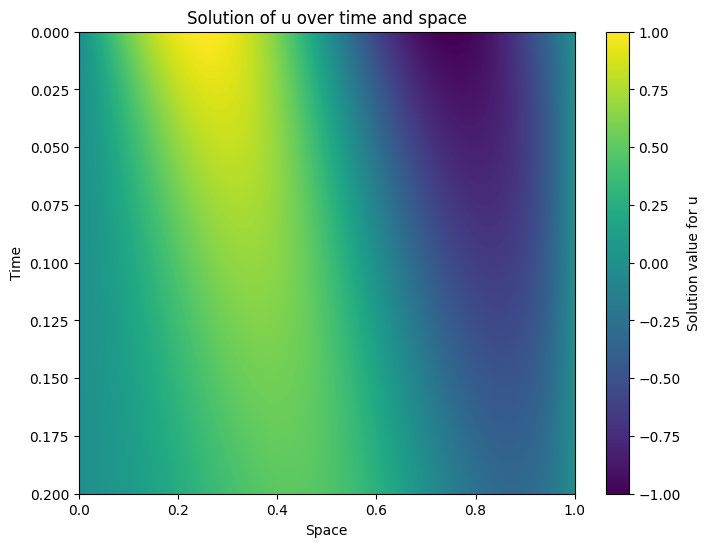

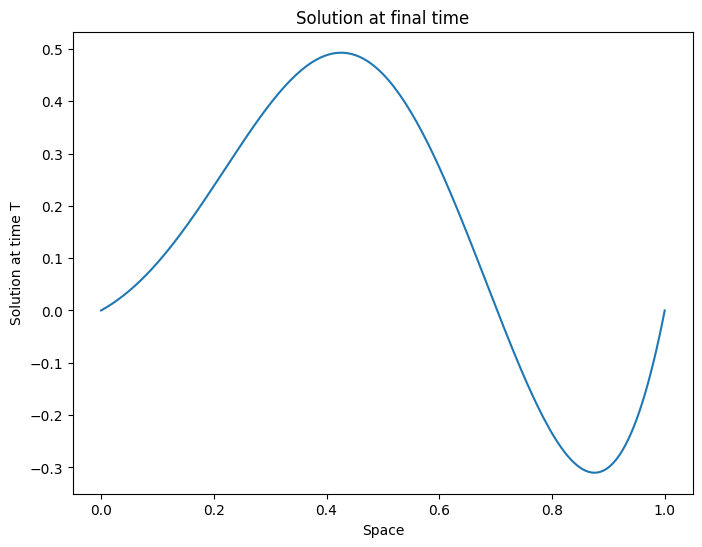

In [ ]:
# Test our code for data generation on a particular PDE
# Convection-diffusion eqn u_{t} =  - a*u_x + niu*u_{xx} with a = 1, niu = 0.1
# Boundary condition: U(0, T) = U(X, t) = 0
# Initial condition: U(x, 0) = sin(2*pi*x)
# We get data first by simulation using Crank-Nicolson scheme

# Parameters of equtaions
a = 1
niu = 0.1

# Scheme constants
delta_x = 0.005
delta_t = 0.001
T = 0.2
X = 1
nx = int(X/delta_x) # nx = 200, nt = 200
nt = int(T/delta_t)

# Initial and boundary condition
x = np.linspace(0, X, nx+1)
u_n0 = np.sin(2*np.pi*x) # Initial condition
u_0n = np.zeros(nt + 1) # Boundary condition

# Matrix elements
r = delta_t/delta_x**2
gamma = delta_t/delta_x
LHS_below_diagonal = -(gamma*a/4 + r*niu/2)
LHS_diagonal = 1 + niu*r
LHS_above_diagonal = gamma*a/4 - r*niu/2
RHS_below_diagonal = gamma*a/4 + r*niu/2
RHS_diagonal = 1 - niu*r
RHS_above_diagonal = - (gamma*a/4 - r*niu/2)

# Set up coefficeint matrix on the LHS and RHS
matrix_LHS = np.zeros((nx -1, nx -1))
for i in range (0, nx-1):
  matrix_LHS[i, i] = LHS_diagonal
  if i>0:
    matrix_LHS[i, i-1] = LHS_below_diagonal
  if i<nx-2:
    matrix_LHS[i, i+1] = LHS_above_diagonal

matrix_RHS = np.zeros((nx -1, nx -1))
for i in range (0, nx-1):
  matrix_RHS[i, i] = RHS_diagonal
  if i>0:
    matrix_RHS[i, i-1] = RHS_below_diagonal
  if i<nx-2:
    matrix_RHS[i, i+1] = RHS_above_diagonal

# Set up solution matrix for u
matrix_sol = np.zeros((nt + 1, nx + 1))
matrix_sol[0, :] = u_n0
matrix_sol[:, 0] = u_0n
matrix_sol[:, nx] = u_0n

# Solve linear system to update
for i in range (1, nt+1):
  b = np.dot(matrix_RHS, matrix_sol[i-1, 1:nx])
  matrix_sol[i, 1:nx] = np.linalg.solve(matrix_LHS, b)

# Draw the graphs
plt.figure(figsize = (8, 6))
plt.imshow(matrix_sol, aspect = 'auto', extent = [0, X, T, 0], cmap = 'viridis')
plt.colorbar(label = "Solution value for u")
plt.xlabel("Space")
plt.ylabel("Time")
plt.title("Solution of u over time and space")

plt.figure(figsize = (8, 6))
plt.plot(x, matrix_sol[-1, :])
plt.xlabel('Space')
plt.ylabel("Solution at time T")
plt.title("Solution at final time")

# Build U
U = matrix_sol # size(A) = (nt+1, nx+1) = (101, 101), larger row/column greater t/x
print(U)

In [ ]:
# We transform the PDE data into suitable form and compute the feature matrix W

# Transpose spatial and temporal dimension for data and let it be the first and
# only row of u_hat (because there is only one equation to identify)
u_hat = np.expand_dims(np.transpose(U), axis=0)

# Construct dictionary for testing; we explore monimial power of u to at most 3
# and only the spatial derivatives, with order at most 3
# The first candidate terms in the dictionary corresponds to u_t. So the first
# Colomn of the algorrithm's output corresponds to b in b = Wc.
dict_list = np.array([[1, 0, 1], [0, 0, 0], [1, 0, 0], [1, 1, 0], [1, 2, 0],
 [2, 0, 0], [2, 1, 0], [2, 2, 0],[3, 0, 0], [3, 1, 0], [3, 2, 0]])

# Constuct xs
xs = np.array([np.arange(nx+1)*delta_x, np.arange(nt+1)*delta_t])

# Set parameters for ident (maximum order of derivative, maximum monomial power
# and whether to allow cross derivative)
max_dx = 3
max_poly = 3
skip_x = 5
skip_t = 6
use_cross_der = True

# Do the data generation for feature matrix
W = data_preparation(u_hat, xs, dict_list, max_dx, max_poly, skip_x, skip_t,
                       use_cross_der)
print("\n W： \n")
print(W)
print("\n")
print("W's shape: \n")
print(W.shape)

mx: 27
mt: 21
Start building feature matrix W:
subsampling_idx: [array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
        55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105.,
       110., 115., 120., 125., 130., 135., 140., 145.]), array([  0.,   6.,  12.,  18.,  24.,  30.,  36.,  42.,  48.,  54.,  60.,
        66.,  72.,  78.,  84.,  90.,  96., 102., 108., 114., 120., 126.,
       132., 138., 144., 150., 156.])]

 W： 

[[-0.49105281  0.08151466  0.04872886 ...  0.01989212  0.35632694
   2.73898463]
 [-0.49542526  0.08151466  0.05659904 ...  0.0294907   0.40414009
   0.96449738]
 [-0.47585739  0.08151466  0.06319881 ...  0.03966488  0.40021846
  -1.32547417]
 ...
 [ 0.30372365  0.08151466 -0.02656423 ... -0.00302245 -0.03494819
   0.24789304]
 [ 0.2916584   0.08151466 -0.02899285 ... -0.003777   -0.02377685
   0.63852418]
 [ 0.27253655  0.08151466 -0.03004175 ... -0.0041389  -0.00405409
   0.90497655]]


W's shape: 

(810, 11)


In [ ]:
# We store the W matrix to google drive, from which it can be imported to
# the second part of the tutorial: PDE identification using Weakform

from google.colab import drive
drive.mount('/content/drive')

import pickle

with open('/content/drive/My Drive/WeakIdent_tutorial_W.pkl', 'wb') as f:
    pickle.dump(W, f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
